In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
late_shipments = pd.read_feather(r".\28_Hypothesis_Testing_in_Python\datasets\late_shipments.feather")
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


### **Test for single proportions**
In Chapter 1, you calculated a p-value for a test hypothesizing that the proportion of late shipments was **greater than** 6%. In that chapter, you used a bootstrap distribution to estimate the standard error of the statistic. An alternative is to use an equation for the standard error based on the sample proportion, hypothesized proportion, and sample size.
You'll revisit the p-value using this simpler calculation.

In [3]:
late_shipments['late'].value_counts(normalize=True)

No     0.939
Yes    0.061
Name: late, dtype: float64

In [4]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of late shipments
p_hat = late_shipments['late'].value_counts(normalize=True)['Yes']

# Calculate the sample size
n = len(late_shipments)

# Print p_hat and n
print(p_hat, n)

0.061 1000


In [5]:
# Calculate the numerator and denominator of the test statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1- p_0)/ n)

# Calculate the test statistic
z_score = numerator/denominator

# Print the result
print(z_score)

0.13315591032282698


In [6]:
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(p_value)

0.44703503936503364


### **Test for two proportions**
You may wonder if the amount paid for freight affects whether or not the shipment was late. Recall that in the late_shipments dataset, whether or not the shipment was late is stored in the late column. Freight costs are stored in the freight_cost_group column, and the categories are "expensive" and "reasonable".

The hypotheses to test, with "late" corresponding to the proportion of late shipments for that group, are

![image info](./28_Hypothesis_Testing_in_Python\slides\Capturar.PNG)

p_hats contains the estimates of population proportions (sample proportions) for the "expensive" and "reasonable" groups. ns contains the sample sizes for these groups. p_hats and ns have been printed for you.

Calculate the pooled sample proportion, from p_hats and ns.

![image info](./28_Hypothesis_Testing_in_Python\slides\Capturar2.PNG)

In [7]:
p_hats = late_shipments[['freight_cost_groups','late']].value_counts(normalize=True)[[('expensive','Yes'),('reasonable','Yes')]]
print(p_hats)

freight_cost_groups  late
expensive            Yes     0.042596
reasonable           Yes     0.016227
dtype: float64


In [8]:
ns = late_shipments['freight_cost_groups'].value_counts(normalize=False)
print(ns)

expensive     531
reasonable    455
Name: freight_cost_groups, dtype: int64


In [9]:
# Calculate the pooled estimate of the population proportion
p_hat = ((ns['expensive'] * p_hats['expensive'].values)+ (ns['reasonable'] * p_hats['reasonable'].values))/(ns['expensive']+ns['reasonable'])

# Print the result
print(p_hat)

[0.03042802]


![image info](./28_Hypothesis_Testing_in_Python\slides\Capturar3.PNG)

In [10]:
# Calculate p_hat one minus p_hat
p_hat_times_not_p_hat = (p_hat * (1-p_hat))

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns =  (p_hat_times_not_p_hat/ns['expensive']) + (p_hat_times_not_p_hat/ns['reasonable'])

# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

# Print the result
print(std_error)

[0.01097267]


![image info](./28_Hypothesis_Testing_in_Python\slides\Capturar4.PNG)

In [11]:
# Calculate the z-score
z_score = (p_hats['expensive'].values - p_hats['reasonable'].values) / std_error
print(z_score)

[2.40316757]


In [12]:
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print p_value
print(p_value)

[0.00812687]


![image info](./28_Hypothesis_Testing_in_Python\slides\Capturar5.PNG)

In [13]:
from statsmodels.stats.proportion import proportions_ztest

In [14]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby('freight_cost_groups')['late'].value_counts()

# Print the counts
print(late_by_freight_cost_group)

freight_cost_groups  late
expensive            No      489
                     Yes      42
reasonable           No      439
                     Yes      16
Name: late, dtype: int64


In [15]:
# Put the two "Yes" counts into an array
success_counts = np.array([late_by_freight_cost_group[('expensive','Yes')],late_by_freight_cost_group[('reasonable','Yes')]])

# Put the two group counts into an array
n = np.array([late_by_freight_cost_group[('expensive','Yes')]+late_by_freight_cost_group[('expensive','No')],late_by_freight_cost_group[('reasonable','Yes')]+late_by_freight_cost_group[('reasonable','No')]])

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative='larger')


# Print the results
print(stat, p_value)

2.922648567784529 0.001735340002359578


#### **Chi-square test of independence**
The chi-square independence test compares proportions of successes of one categorical variable across the categories of another categorical variable.

Trade deals often use a form of business shorthand in order to specify the exact details of their contract. These are International Chamber of Commerce (ICC) international commercial terms, or incoterms for short.

The late_shipments dataset includes a vendor_inco_term that describes the incoterms that applied to a given shipment. The choices are:

- EXW: "Ex works". The buyer pays for transportation of the goods.
- CIP: "Carriage and insurance paid to". The seller pays for freight and insurance until the goods board a ship.
- DDP: "Delivered duty paid". The seller pays for transportation of the goods until they reach a destination port.
- FCA: "Free carrier". The seller pays for transportation of the goods.
Perhaps the incoterms affect whether or not the freight costs are expensive. Test these hypotheses with a significance level of 0.01.

![image info](./28_Hypothesis_Testing_in_Python\slides\Capturar6.PNG)

In [16]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

# Print props
print(props)

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
DDU               reasonable             1.000000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: freight_cost_groups, dtype: float64


In [17]:
# Convert props to wide format
wide_props = props.unstack()

# Print wide_props
print(wide_props)

freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.320000    0.680000
DDP                   0.550000    0.450000
DDU                        NaN    1.000000
EXW                   0.583448    0.416552
FCA                   0.336364    0.663636


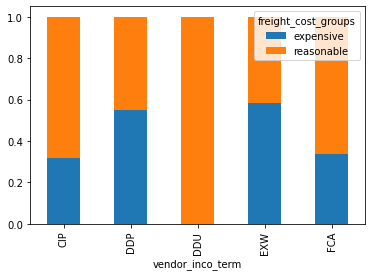

In [18]:
# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind='bar', stacked=True)
plt.show()

In [19]:
import pingouin

In [22]:
wide_props

freight_cost_groups,expensive,reasonable
vendor_inco_term,,
CIP,0.320000,0.680000
DDP,0.550000,0.450000
DDU,NaN,1.000000
EXW,0.583448,0.416552
FCA,0.336364,0.663636


In [23]:
# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pingouin.chi2_independence(data=late_shipments, x='freight_cost_groups', y='vendor_inco_term')

# Print results
print(stats[stats['test'] == 'pearson']) 

      test  lambda       chi2  dof          pval    cramer     power
0  pearson     1.0  34.805072  4.0  5.093922e-07  0.186561  0.999235


c:\Users\vnlvi\Anaconda3\lib\site-packages\pingouin\contingency.py:150: UserWarning: Low count on observed frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
c:\Users\vnlvi\Anaconda3\lib\site-packages\pingouin\contingency.py:150: UserWarning: Low count on expected frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
c:\Users\vnlvi\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\vnlvi\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\vnlvi\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


Reject the null hypothesis and conclude that vendor_inco_term and freight_cost_group are associated.

### **Visualizing goodness of fit**
The chi-square goodness of fit test compares proportions of each level of a categorical variable to hypothesized values. Before running such a test, it can be helpful to visually compare the distribution in the sample to the hypothesized distribution.

Recall the vendor incoterms in the late_shipments dataset. You hypothesize that the four values occur with these frequencies in the population of shipments.

- EXW: 0.75
- CIP: 0.05
- DDP: 0.1
- FCA: 0.1

These frequencies are stored in the hypothesized DataFrame.

The incoterm_counts DataFrame stores the .value_counts() of the vendor_inco_term column.

In [42]:
incoterm_counts = late_shipments['vendor_inco_term'].value_counts()
incoterm_counts = incoterm_counts.rename_axis('vendor_inco_term').reset_index(name='n')
incoterm_counts = incoterm_counts[incoterm_counts['n']>1]
incoterm_counts

,vendor_inco_term,n
0,EXW,732
1,FCA,111
2,DDP,100
3,CIP,56


In [38]:
# Find the number of rows in late_shipments
n_total = len(late_shipments[late_shipments['vendor_inco_term']!='DDU'])

# Print n_total
print(n_total)

999


In [44]:
# Create n column that is prop column * n_total
hypothesized = pd.DataFrame({
    'vendor_inco_term':['EXW','CIP','DDP','FCA'],
    'prop': [0.75,0.05,0.1,0.1],
})
hypothesized['n'] = hypothesized['prop'] * n_total
# Print the modified hypothesized DataFrame
print(hypothesized)

  vendor_inco_term  prop       n
0              EXW  0.75  749.25
1              CIP  0.05   49.95
2              DDP  0.10   99.90
3              FCA  0.10   99.90


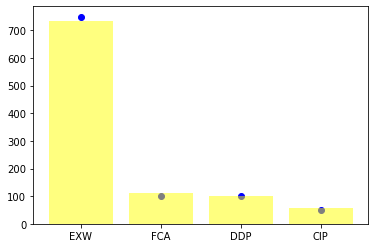

In [46]:
# Make a yellow bar graph of vendor_inco_term versus n
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], color='yellow',alpha=0.5)
# Add blue points for hypothesized counts
plt.scatter(hypothesized['vendor_inco_term'], hypothesized['n'],color='blue')
# Add blue points for hypothesized counts
plt.show()

### **Chi-square test of goodness of fit**
The bar plot of vendor_inco_term suggests that the distribution across the four categories was quite close to the hypothesized distribution. You'll need to perform a chi-square goodness of fit test to see whether the differences are statistically significant.

Recall the hypotheses for this type of test:

H0: The sample matches with the hypothesized distribution.

Ha: The sample does not match with the hypothesized distribution.

To decide which hypothesis to choose, we'll set a significance level of 0.1.

In [47]:
from scipy.stats import chisquare

In [50]:
chisquare(f_obs=incoterm_counts['n'], f_exp=hypothesized['n'])

Power_divergenceResult(statistic=94.3053053053053, pvalue=2.6037864328450376e-20)

Reject the null hypothesis and conclude that vendor_inco_term does not follow the distribution specified by hypothesized_props.